
Reconhecimento de comandos de voz

image-2.png

Base de dados: Mini Speech Commands

O conjunto de dados original consiste em mais de 105.000 arquivos de áudio no formato de arquivo de áudio WAV (Waveform) de pessoas dizendo 35 palavras diferentes. Mais detalhes sobre a base de dados podem ser vistos nestes link: speech_commands

Para economizar tempo com o carregamento de dados, será usada uma versão menor do conjunto de dados de Comandos de Fala chamada mini_speech_commands que contém clipes de áudio curtos (um segundo ou menos) de 8 comandos: "down", "go", "left", "no", "right", "stop", "up" e "yes".

A taxa de amostragem para este conjunto de dados é de 16kHz.

In [1]:
#Importando as bibliotecas

# Instala a versão específica 0.8.1 da biblioteca librosa.
!pip install --upgrade librosa
#==0.8.1
!pip install --upgrade numpy

# Verifica a versão do librosa
#print(librosa.__version__)
#librosa.__version__

In [2]:

# Importação de bibliotecas e módulos necessários.
import glob
import os
import pathlib
import random
from datetime import datetime
import numpy as np
import librosa
import librosa.display as ld
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import Audio
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import models
import seaborn as sns
sns.set()
from tqdm import tqdm


In [3]:
import os

dir_dataset = "D:/Dados/material_complementar_reconhecimento_voz/mini_speech_commands/"

if os.path.exists(dir_dataset):
    print("O diretório existe.")
else:
    print("O diretório não existe.")

O diretório existe.


In [4]:
#Análise exploratória de dados (EDA)

#Baixando e carregando o dataset Mini Speech Commands
# Baixa e descompacta o dataset Mini Speech Commands.
#!wget http://storage.googleapis.com/download.tensorflow.org/data/mini_speech_commands.zip -O mini_speech_commands.zip
#!unzip mini_speech_commands.zip -d dir_files
#!rm mini_speech_commands.zip


##Comando para Vscode
import os
import urllib.request
import zipfile

# URL do arquivo zip
url = "http://storage.googleapis.com/download.tensorflow.org/data/mini_speech_commands.zip"

# Nome do arquivo zip
zip_filename = "mini_speech_commands.zip"

# Diretório de destino para extrair o arquivo zip
extract_dir = "D:/Dados/material_complementar_reconhecimento_voz/mini_speech_commands/"

# Baixar o arquivo zip
urllib.request.urlretrieve(url, zip_filename)

# Extrair o arquivo zip
with zipfile.ZipFile(zip_filename, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

# Remover o arquivo zip após a extração
os.remove(zip_filename)


In [5]:
#Excluir arquivos desnecessários
caminho_arquivo = "D:\Dados\Material_complementar_reconhecimento_voz\mini_speech_commands\mini_speech_commands\README.md"  # Substitua pelo caminho real do arquivo

import os

try:
  os.remove(caminho_arquivo)
  print("Arquivo excluído com sucesso!")
except FileNotFoundError:
  print(f"Erro: Arquivo não encontrado em {caminho_arquivo}")
except PermissionError:
  print(f"Erro: Sem permissão para excluir o arquivo em {caminho_arquivo}")



# Definindo o caminho do diretório (substitua com o caminho real)
diretorio_a_excluir = "D:\\Dados\Material_complementar_reconhecimento_voz\\mini_speech_commands\\__MACOSX"  # Substitua com o seu caminho

import shutil

try:
  # Tente remover o diretório recursivamente
  shutil.rmtree(diretorio_a_excluir)
  print("Diretório excluído com sucesso e todos os seus conteúdos!")
except OSError as e:
  # Trate possíveis erros (por exemplo, problemas de permissão)
  print(f"Erro ao excluir o diretório: {e}")


Arquivo excluído com sucesso!
Diretório excluído com sucesso e todos os seus conteúdos!


In [6]:
# Cria uma lista dos comandos disponíveis no dataset.
#Bibliotecas auxiliares
import os
import glob

#Google Colab
#commands = []
#dir_comands = "D:/Dados/Material_complementar_reconhecimento_voz/mini_speech_commands/mini_speech_commands/"

#for name in glob.glob(str(dir_comands) + '/*' + os.path.sep):
#  print(name.split('/')[-2])
#  commands.append(name.split('/')[-2])


# VSCode Jupyter
commands = []
dir_commands = "D:/Dados/Material_complementar_reconhecimento_voz/mini_speech_commands/mini_speech_commands/"

for name in glob.glob(os.path.join(dir_commands, '*')):
    print(os.path.basename(name))
    commands.append(os.path.basename(name))

down
go
left
no
right
stop
up
yes


In [7]:
# Cria um dicionário para mapear os comandos para índices numéricos.
commands_dict = {i: commands.index(i) for i in commands}
print(commands_dict)

{'down': 0, 'go': 1, 'left': 2, 'no': 3, 'right': 4, 'stop': 5, 'up': 6, 'yes': 7}


In [8]:
# Cria uma lista com os caminhos de todos os arquivos de áudio.

import os
import glob
from tqdm import tqdm

speech_data_list = []
dir_speech_data_list = "D:/Dados/Material_complementar_reconhecimento_voz/mini_speech_commands/mini_speech_commands"
for name in tqdm(glob.glob(str(dir_speech_data_list) + '/*/*')):
  speech_data_list.append(name)

100%|██████████| 8000/8000 [00:00<00:00, 1286991.10it/s]


In [9]:
# Embaralha a lista de dados de fala.

import os
import glob
import random
from tqdm import tqdm

random.seed(42)
random.shuffle(speech_data_list)

In [10]:
# Extrai os rótulos dos dados de fala.
speech_data_labels = []
for audio in tqdm(speech_data_list):
  speech_data_labels.append(os.path.dirname(audio).split('/')[-1])

100%|██████████| 8000/8000 [00:00<00:00, 145669.70it/s]


In [11]:
# Converte os rótulos de texto para índices numéricos.
#speech_label_int = []
#for audio in tqdm(speech_data_labels):
#  speech_label_int.append(commands_dict[audio])

#Vscode Jupyter
unique_labels = set(speech_data_labels)
commands_dict = {label: index for index, label in enumerate(unique_labels)}


speech_label_int = [commands_dict[label] for label in tqdm(speech_data_labels)]

100%|██████████| 8000/8000 [00:00<?, ?it/s]


In [12]:
# Carrega os dados de áudio com a taxa de amostragem de 16000 Hz.
!pip install librosa
loaded_speech_data = []
for audio in tqdm(speech_data_list):
  loaded_speech_data.append(librosa.load(audio, sr = 16000))

100%|██████████| 8000/8000 [00:46<00:00, 173.67it/s]


In [13]:
# Cria um DataFrame com rótulos, dados de áudio carregados e caminhos.
df = pd.DataFrame([speech_data_labels, loaded_speech_data, speech_data_list]).T
df

,0,1,2
0,mini_speech_commands\right,"([9.1552734e-05, 3.0517578e-05, 6.1035156e-05,...",D:/Dados/Material_complementar_reconhecimento_...
1,mini_speech_commands\left,"([0.0019226074, 0.0021362305, 0.002319336, 0.0...",D:/Dados/Material_complementar_reconhecimento_...
2,mini_speech_commands\right,"([0.0, 9.1552734e-05, 6.1035156e-05, 9.1552734...",D:/Dados/Material_complementar_reconhecimento_...
3,mini_speech_commands\no,"([-0.00039672852, -0.0005493164, -0.0006408691...",D:/Dados/Material_complementar_reconhecimento_...
4,mini_speech_commands\down,"([0.0, -3.0517578e-05, -0.00012207031, -6.1035...",D:/Dados/Material_complementar_reconhecimento_...
...,...,...,...
7995,mini_speech_commands\left,"([9.1552734e-05, 0.00012207031, 0.00012207031,...",D:/Dados/Material_complementar_reconhecimento_...
7996,mini_speech_commands\up,"([-0.00021362305, -0.0005493164, -0.0016174316...",D:/Dados/Material_complementar_reconhecimento_...
7997,mini_speech_commands\down,"([3.0517578e-05, -6.1035156e-05, 0.0, 3.051757...",D:/Dados/Material_complementar_reconhecimento_...
7998,mini_speech_commands\down,"([6.1035156e-05, 0.00012207031, 0.00015258789,...",D:/Dados/Material_complementar_reconhecimento_...


In [14]:
df.columns = ['command', 'waves', 'path']
df

,command,waves,path
0,mini_speech_commands\right,"([9.1552734e-05, 3.0517578e-05, 6.1035156e-05,...",D:/Dados/Material_complementar_reconhecimento_...
1,mini_speech_commands\left,"([0.0019226074, 0.0021362305, 0.002319336, 0.0...",D:/Dados/Material_complementar_reconhecimento_...
2,mini_speech_commands\right,"([0.0, 9.1552734e-05, 6.1035156e-05, 9.1552734...",D:/Dados/Material_complementar_reconhecimento_...
3,mini_speech_commands\no,"([-0.00039672852, -0.0005493164, -0.0006408691...",D:/Dados/Material_complementar_reconhecimento_...
4,mini_speech_commands\down,"([0.0, -3.0517578e-05, -0.00012207031, -6.1035...",D:/Dados/Material_complementar_reconhecimento_...
...,...,...,...
7995,mini_speech_commands\left,"([9.1552734e-05, 0.00012207031, 0.00012207031,...",D:/Dados/Material_complementar_reconhecimento_...
7996,mini_speech_commands\up,"([-0.00021362305, -0.0005493164, -0.0016174316...",D:/Dados/Material_complementar_reconhecimento_...
7997,mini_speech_commands\down,"([3.0517578e-05, -6.1035156e-05, 0.0, 3.051757...",D:/Dados/Material_complementar_reconhecimento_...
7998,mini_speech_commands\down,"([6.1035156e-05, 0.00012207031, 0.00015258789,...",D:/Dados/Material_complementar_reconhecimento_...


In [15]:
# Quantidade de comandos
df['command'].value_counts()

command
mini_speech_commands\right    1000
mini_speech_commands\left     1000
mini_speech_commands\no       1000
mini_speech_commands\down     1000
mini_speech_commands\yes      1000
mini_speech_commands\go       1000
mini_speech_commands\up       1000
mini_speech_commands\stop     1000
Name: count, dtype: int64

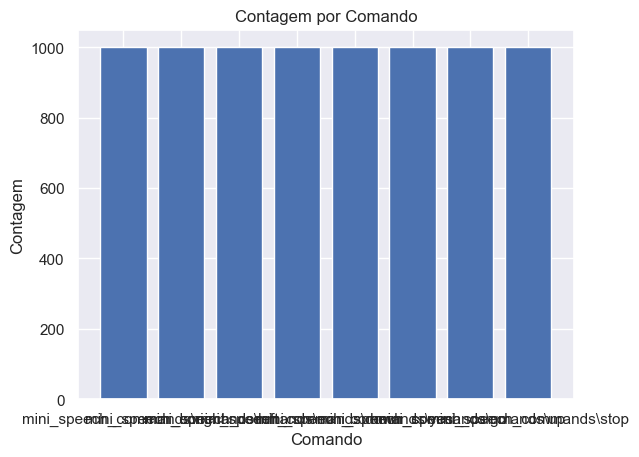

In [16]:
# Visualiza a distribuição de comandos no dataset.
import matplotlib.pyplot as plt
command_counts = df['command'].value_counts()

plt.bar(command_counts.index, command_counts.values)
plt.xlabel('Comando')
plt.ylabel('Contagem')
plt.title('Contagem por Comando')
plt.show()

In [17]:
import os

dir_waves = 'D:/Dados/Material_complementar_reconhecimento_voz/mini_speech_commands/mini_speech_commands/'

if os.path.exists(dir_waves):
    print("O diretório existe.")
else:
    print("O diretório não existe.")

O diretório existe.


In [18]:
# Calcula e visualiza a distribuição da duração das gravações.
duration_of_recordings = []
dir_waves = 'D:/Dados/Material_complementar_reconhecimento_voz/mini_speech_commands/mini_speech_commands/'

for label in commands:
    waves = [f for f in os.listdir( dir_waves + label) if f.endswith('.wav')]
    for wav in waves:
        data, sample_rate = librosa.load(dir_waves + label + '/' + wav, sr = 16000)
        duration_of_recordings.append(float(len(data) / sample_rate))

In [19]:
## Testes

# Calcula e visualiza a distribuição da duração das gravações.
#VScode
#import os

#duration_of_recordings = []
#commands = []
#dir_waves = "D:\Dados\Material_complementar_reconhecimento_voz\mini_speech_commands\mini_speech_commands"

#for label in commands:
    # Verifique se label é um diretório (use os.path.isdir)
    #if os.path.isdir(os.path.join(dir_waves, label)):  # Combine caminhos
        #waves = [f for f in os.listdir(os.path.join(dir_waves, label)) if f.endswith('.wav')]
        #for wav in waves:
            #data, sample_rate = librosa.load(os.path.join(dir_waves, label, wav), sr=16000)
            # Processe os dados de áudio...
            #duration_of_recordings.append(float(len(data) / sample_rate))
    #else:
        # Lide com o caso em que label não é um diretório (por exemplo, imprima uma mensagem)
        #print(f"Pulando a categoria '{label}' pois não é um diretório.")


d:\Anaconda\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


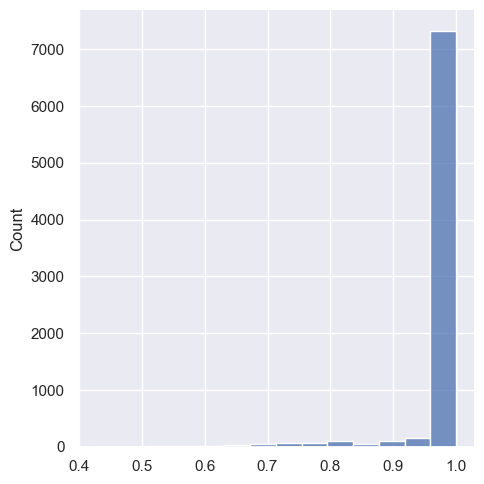

In [20]:
# Duração das gravações
sns.displot(duration_of_recordings);

Canais:  1
Número total de amostras: 15019
Arquivo: D:/Dados/Material_complementar_reconhecimento_voz/mini_speech_commands/mini_speech_commands\right\6cf5459b_nohash_0.wav
Taxa de amostragem: 16000
Duração:  0.9386875


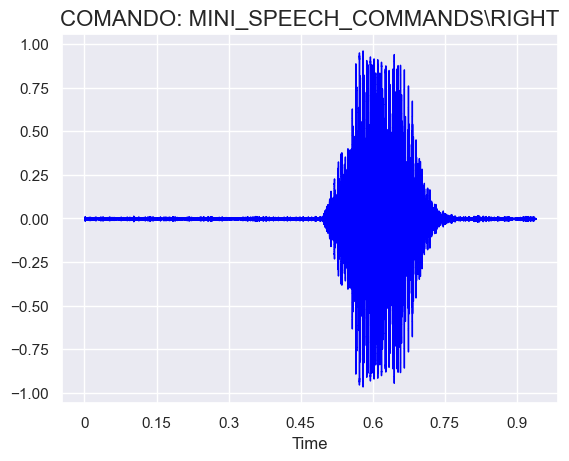

In [21]:
#Visalizando os dados de áudio
#Waveforms

# Determina o número total de arquivos no DataFrame 'df'.
n_files = df.shape[0]
rnd = np.random.randint(0, n_files)
fname = df.path[rnd]
data, sample_rate = librosa.load(fname, sr=16000)

print('Canais: ',  len(data.shape))
print('Número total de amostras:', data.shape[0])
print('Arquivo:', fname)
print('Taxa de amostragem:', sample_rate)
print('Duração: ', len(data) / sample_rate)

# Extrai informações adicionais do DataFrame relacionadas ao arquivo de áudio e exibe a forma de onda (waveform) do áudio.
info = df.iloc[rnd].values
title_txt = f'Comando: {info[0]}'
plt.title(title_txt.upper(), size=16)
librosa.display.waveshow(data, sr=sample_rate,color='blue')
Audio(data = data, rate = sample_rate)

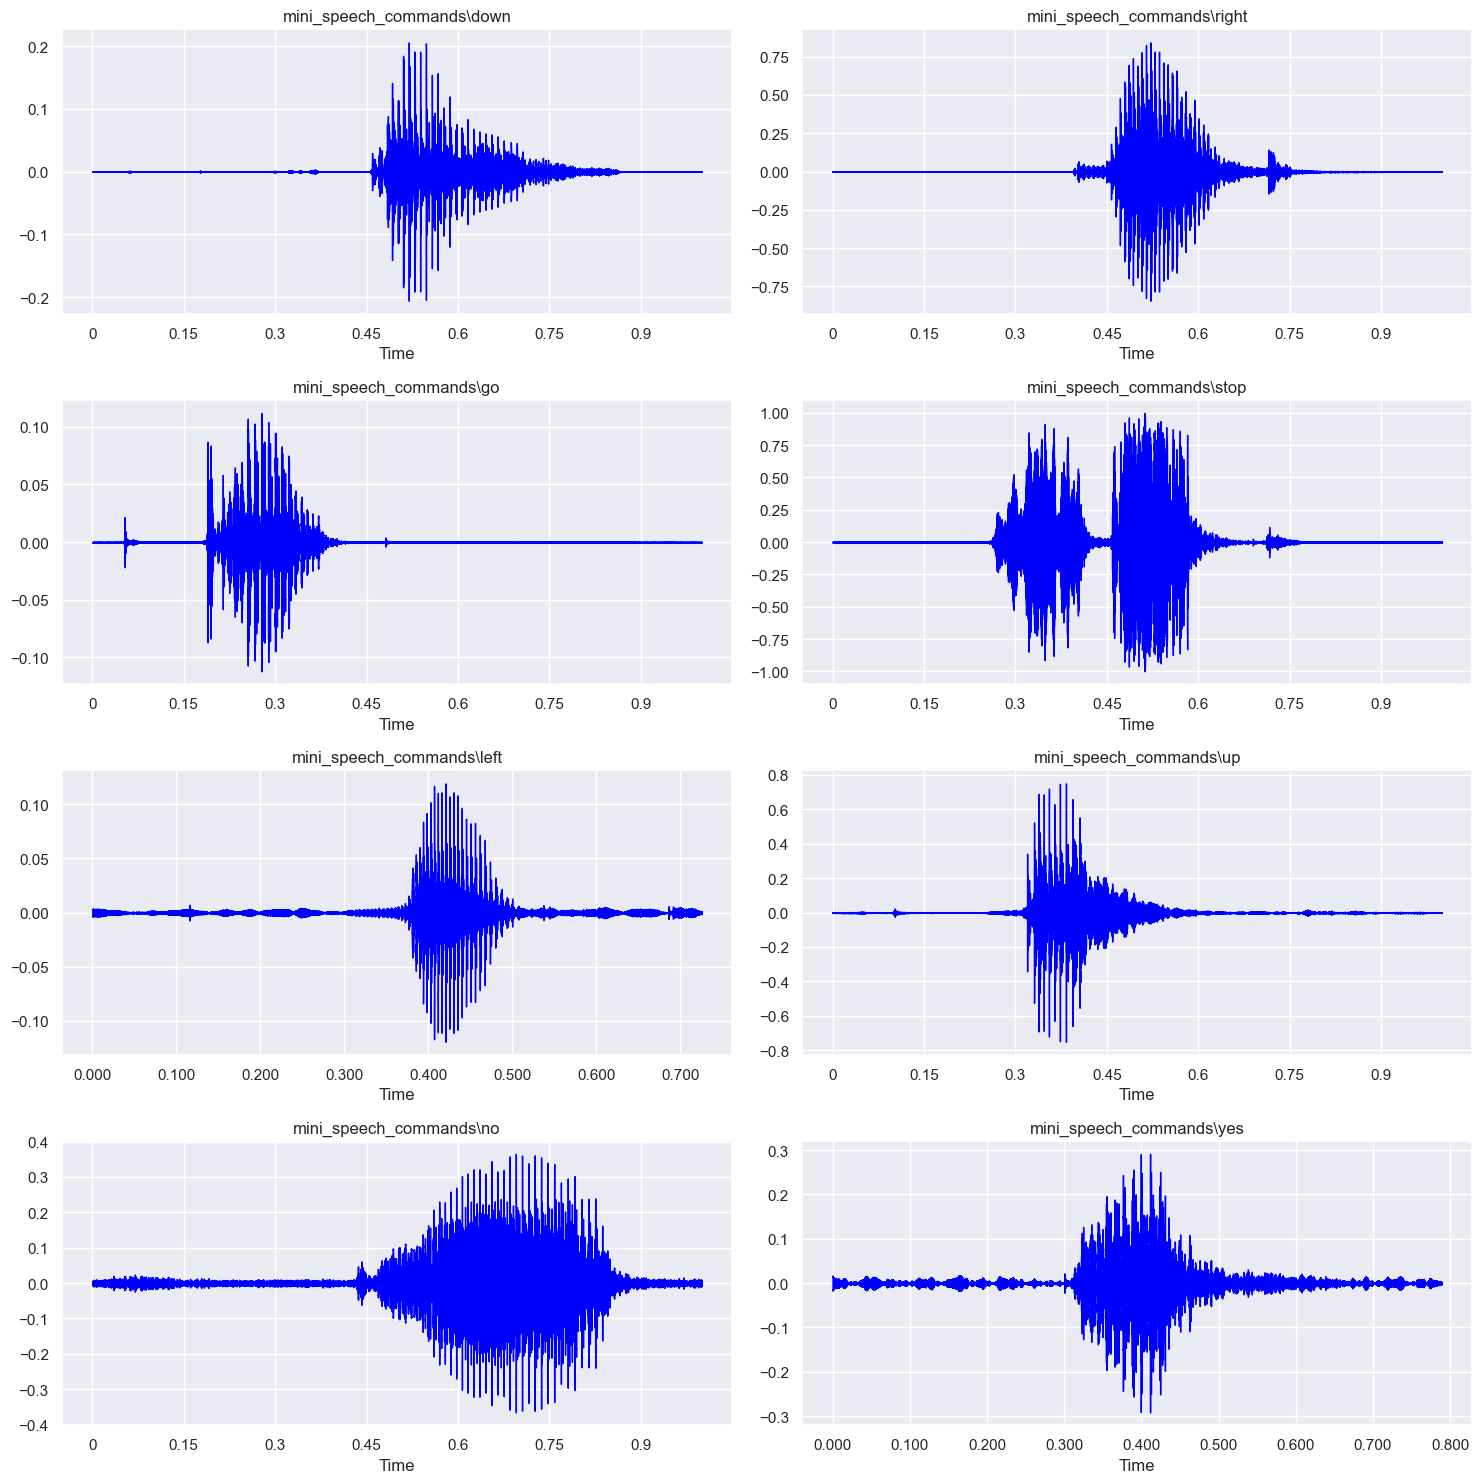

In [22]:
# Seleciona um exemplo aleatório de cada comando (categoria) do DataFrame 'df'.
random_samples = df.groupby('command').sample(1)
audio_samples, labels = random_samples['path'].tolist(), random_samples['command'].tolist()

# Configura o layout para exibir as formas de onda (waveforms) dos arquivos de áudio selecionados.
rows=4
cols=2
fig, axs = plt.subplots(rows, cols, figsize=(15,15))
index = 0
# Itera por cada célula do layout, carrega o arquivo de áudio, exibe sua forma de onda e define o título da célula como o rótulo do comando correspondente.
for col in range(cols):
    for row in range(rows):
        data, sample_rate = librosa.load(audio_samples[index], sr = None)
        librosa.display.waveshow(data, sr=sample_rate, ax=axs[row][col],color='blue')
        axs[row][col].set_title('{}'.format(labels[index]))
        index += 1

# Ajusta o layout para garantir que tudo seja exibido de forma adequada.
fig.tight_layout()

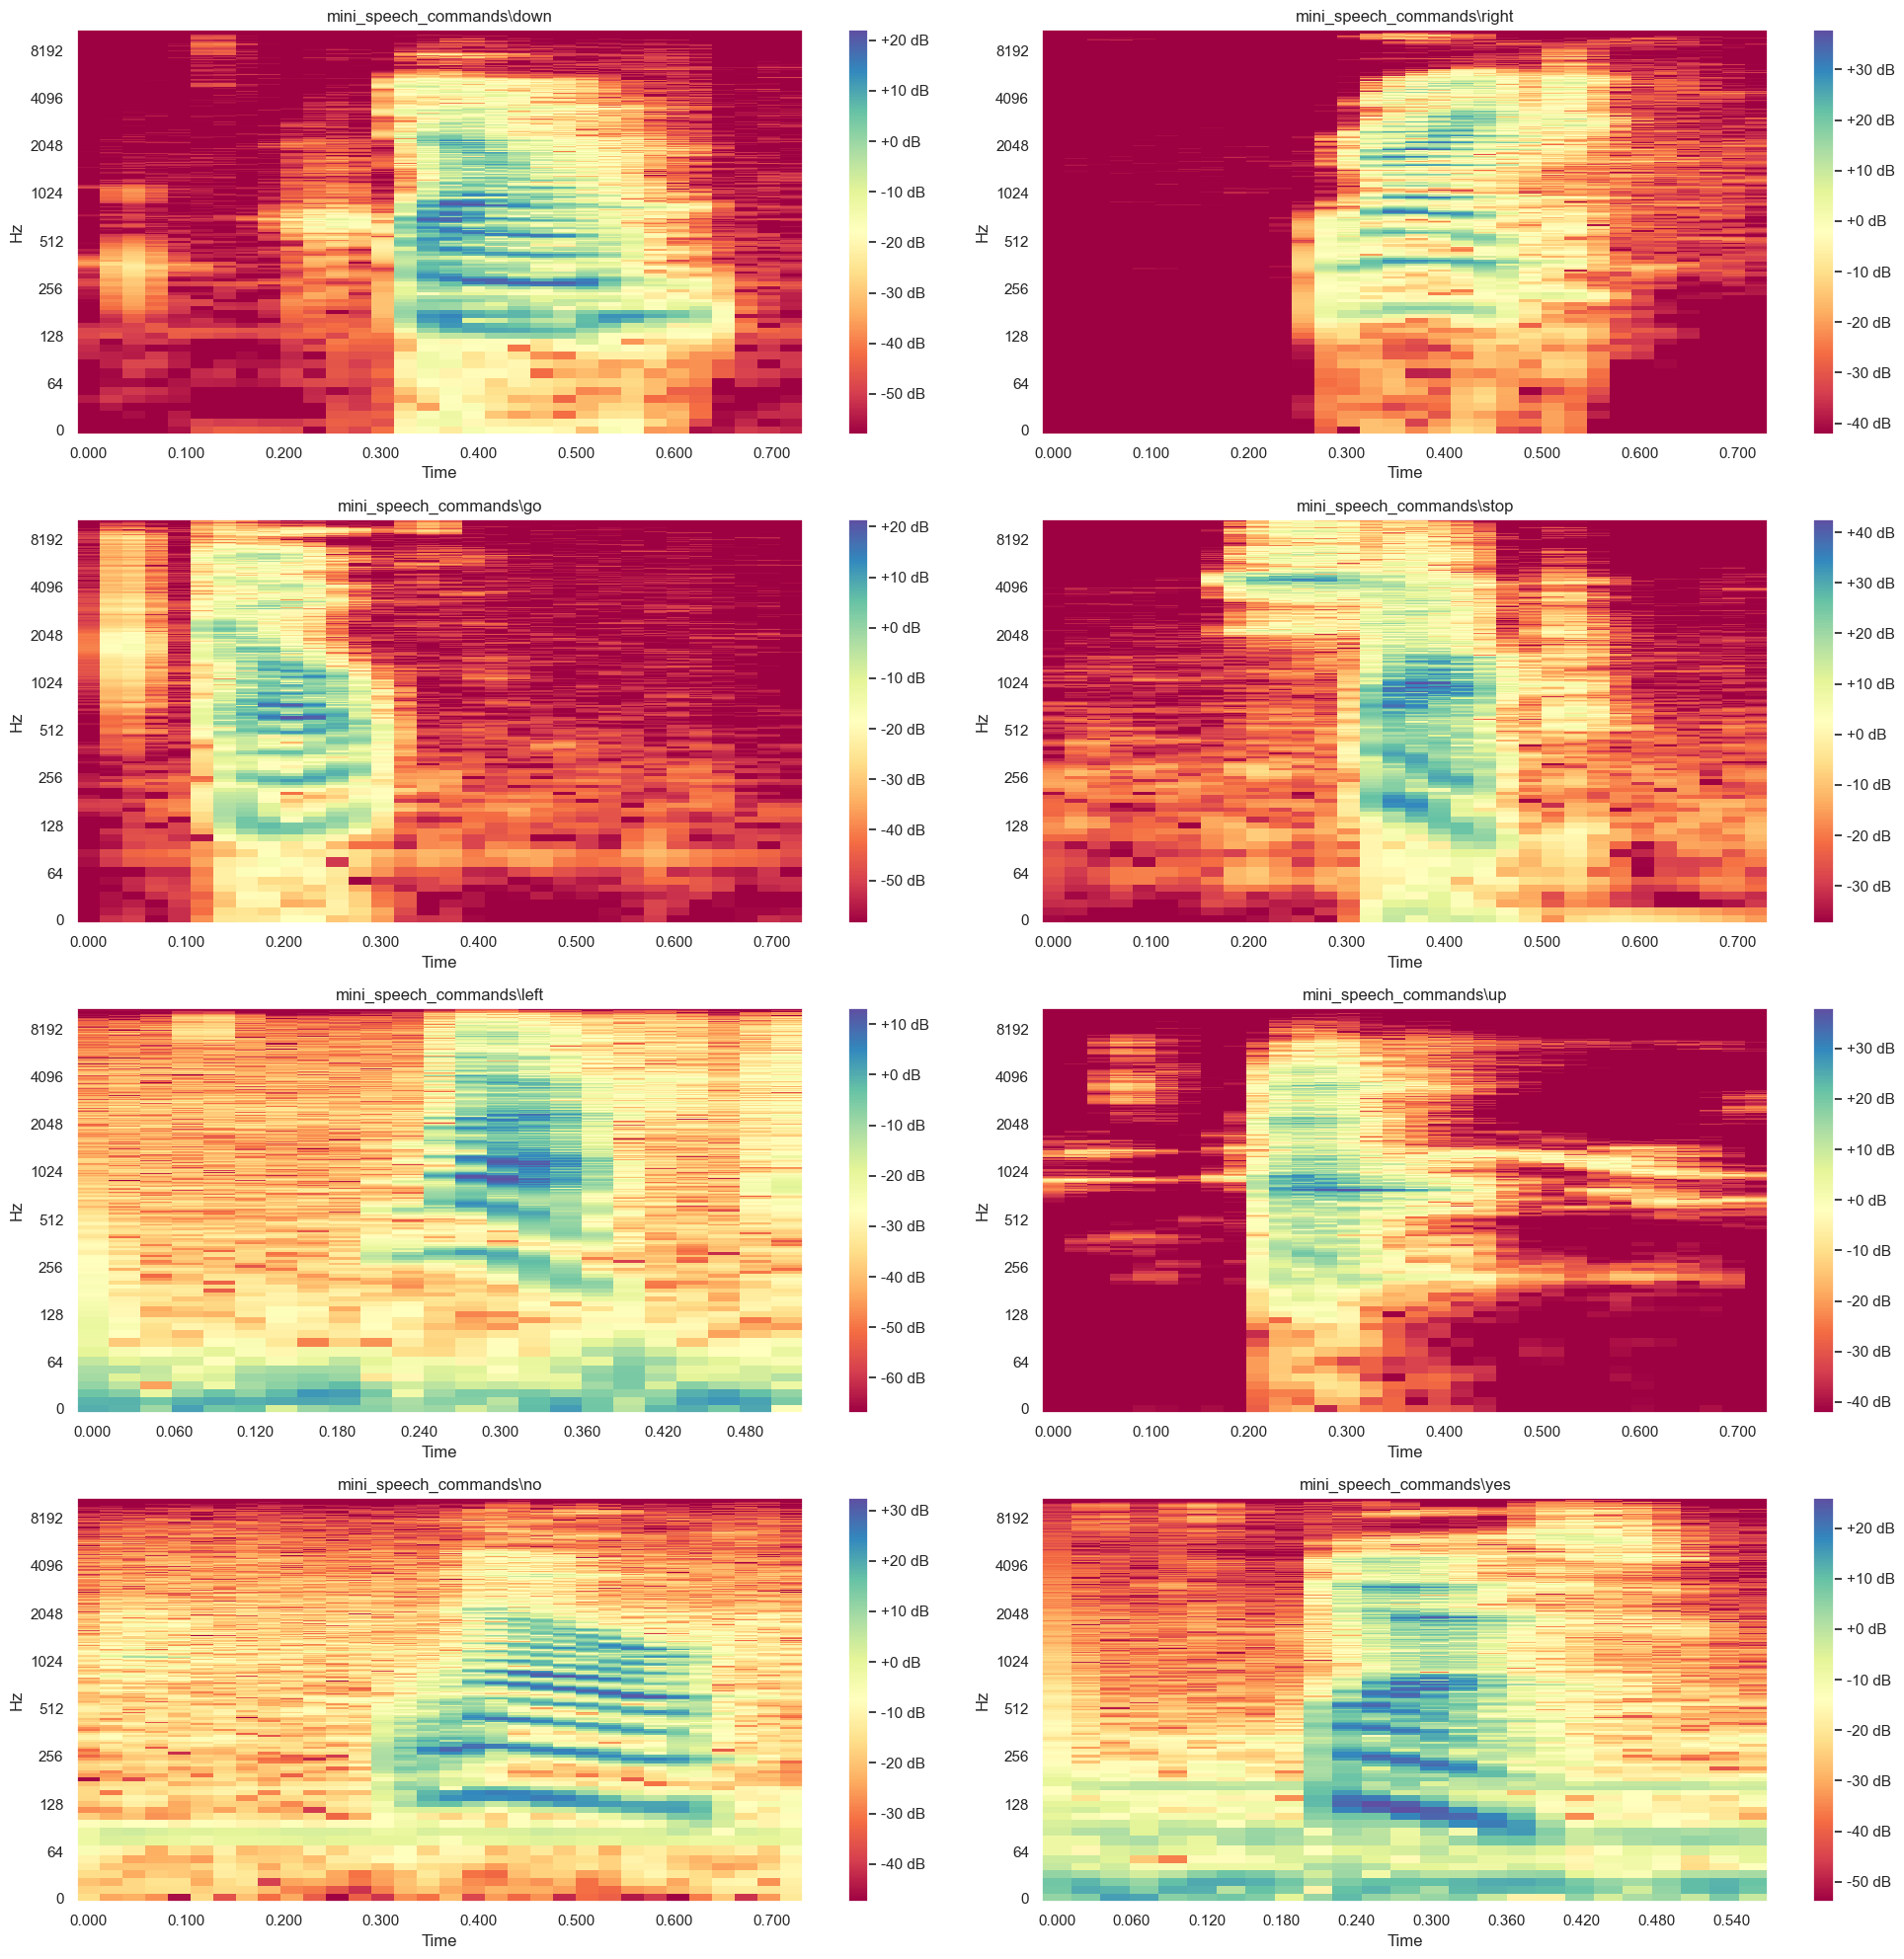

In [23]:
#Espectrogramas de STFT (transformada de Fourier)
# Cria uma nova figura e um array de subplots com 4 linhas e 2 colunas, com tamanho total de 20x20 polegadas.
fig, axs = plt.subplots(rows, cols, figsize=(20,20))
index = 0
# Itera por cada célula do layout para processar e exibir os espectrogramas de STFT (Short-Time Fourier Transform) dos arquivos de áudio selecionados.
for col in range(cols):
    for row in range(rows):
        data, sample_rate = librosa.load(audio_samples[index], sr = None)
        stft = librosa.stft(y = data)
        stft_db = librosa.amplitude_to_db(np.abs(stft))
        img = librosa.display.specshow(stft_db, x_axis="time", y_axis='log', ax=axs[row][col], cmap = 'Spectral')
        axs[row][col].set_title('{}'.format(labels[index]))
        fig.colorbar(img, ax=axs[row][col], format='%+2.f dB')
        index += 1
fig.tight_layout()

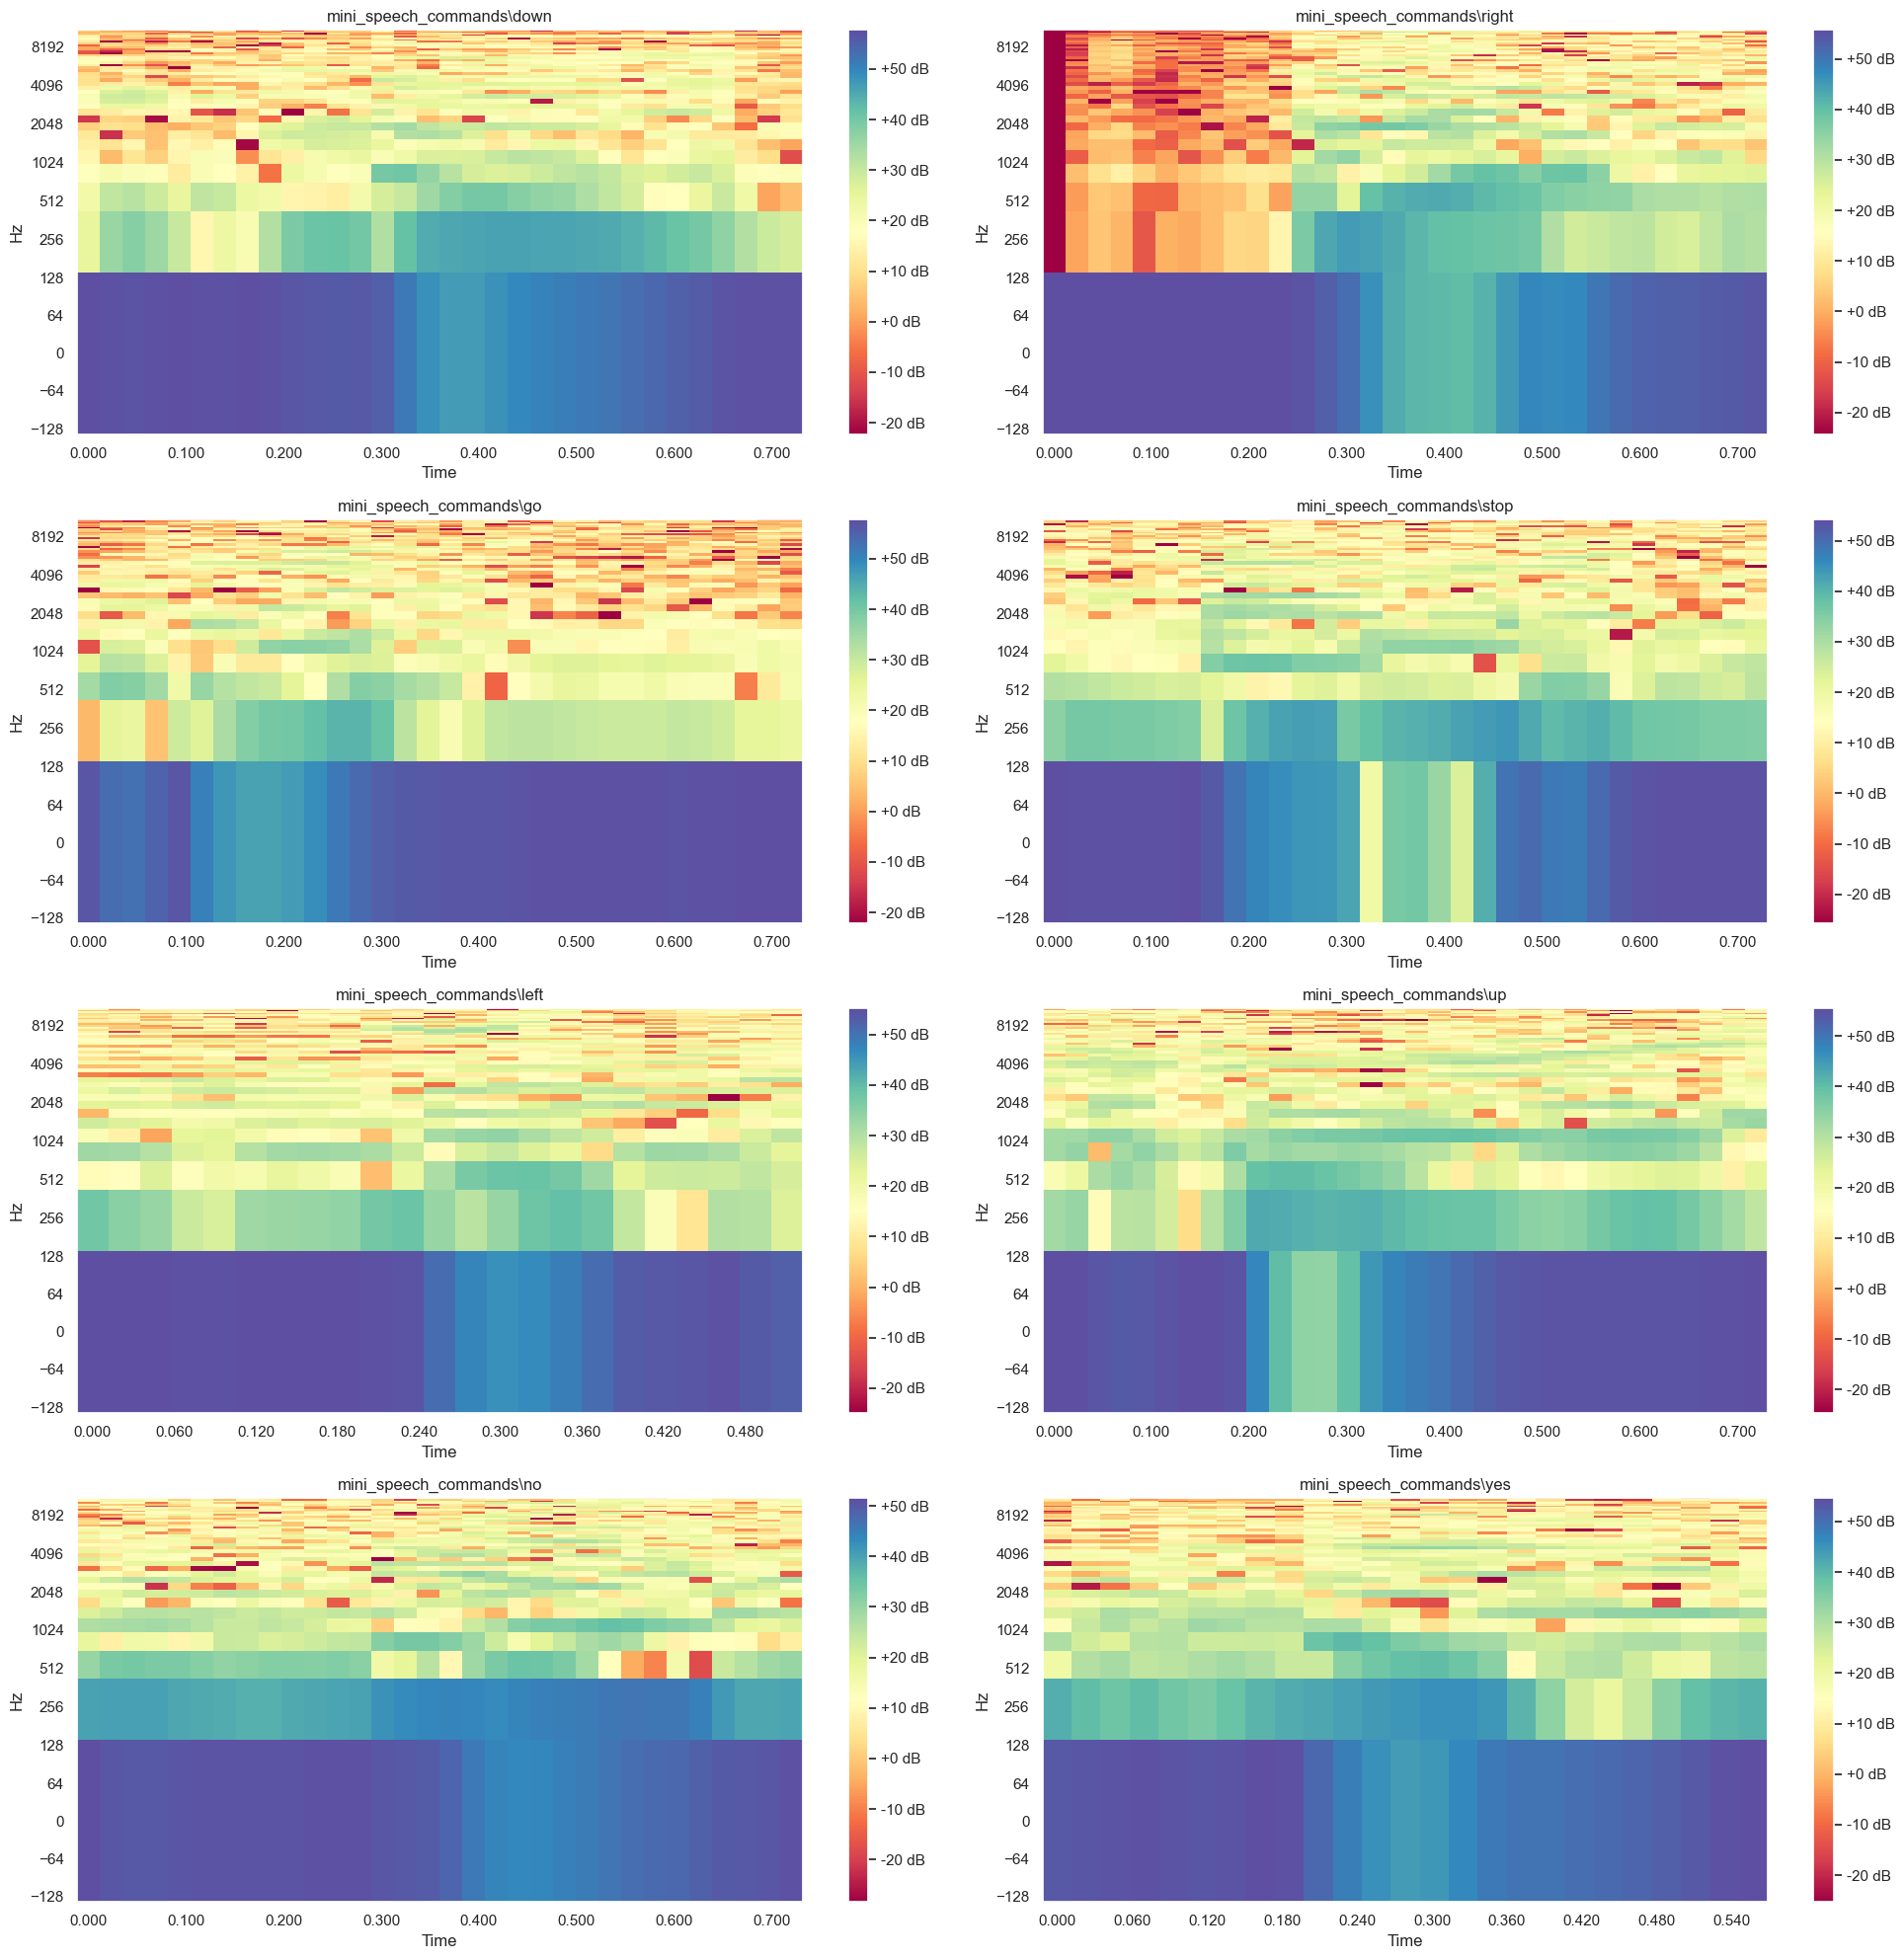

In [24]:
#Espectrogramas de MFCCs

# Cria uma nova figura e um array de subplots com 4 linhas e 2 colunas, com tamanho total de 20x20 polegadas.
fig, axs = plt.subplots(rows, cols, figsize=(20,20))
index = 0
# Itera por cada célula do layout para processar e exibir os espectrogramas de MFCC (Mel-Frequency Cepstral Coefficients) dos arquivos de áudio selecionados.
for col in range(cols):
    for row in range(rows):
        data, sample_rate = librosa.load(audio_samples[index], sr = None)
        mfccs = librosa.feature.mfcc(y = data, sr=sample_rate, n_mfcc=40)
        mfccs_db = librosa.amplitude_to_db(np.abs(mfccs))
        img = librosa.display.specshow(mfccs_db, x_axis="time", y_axis='log', ax=axs[row][col], cmap = 'Spectral')
        axs[row][col].set_title('{}'.format(labels[index]))
        fig.colorbar(img, ax=axs[row][col], format='%+2.f dB')
        index += 1

fig.tight_layout()

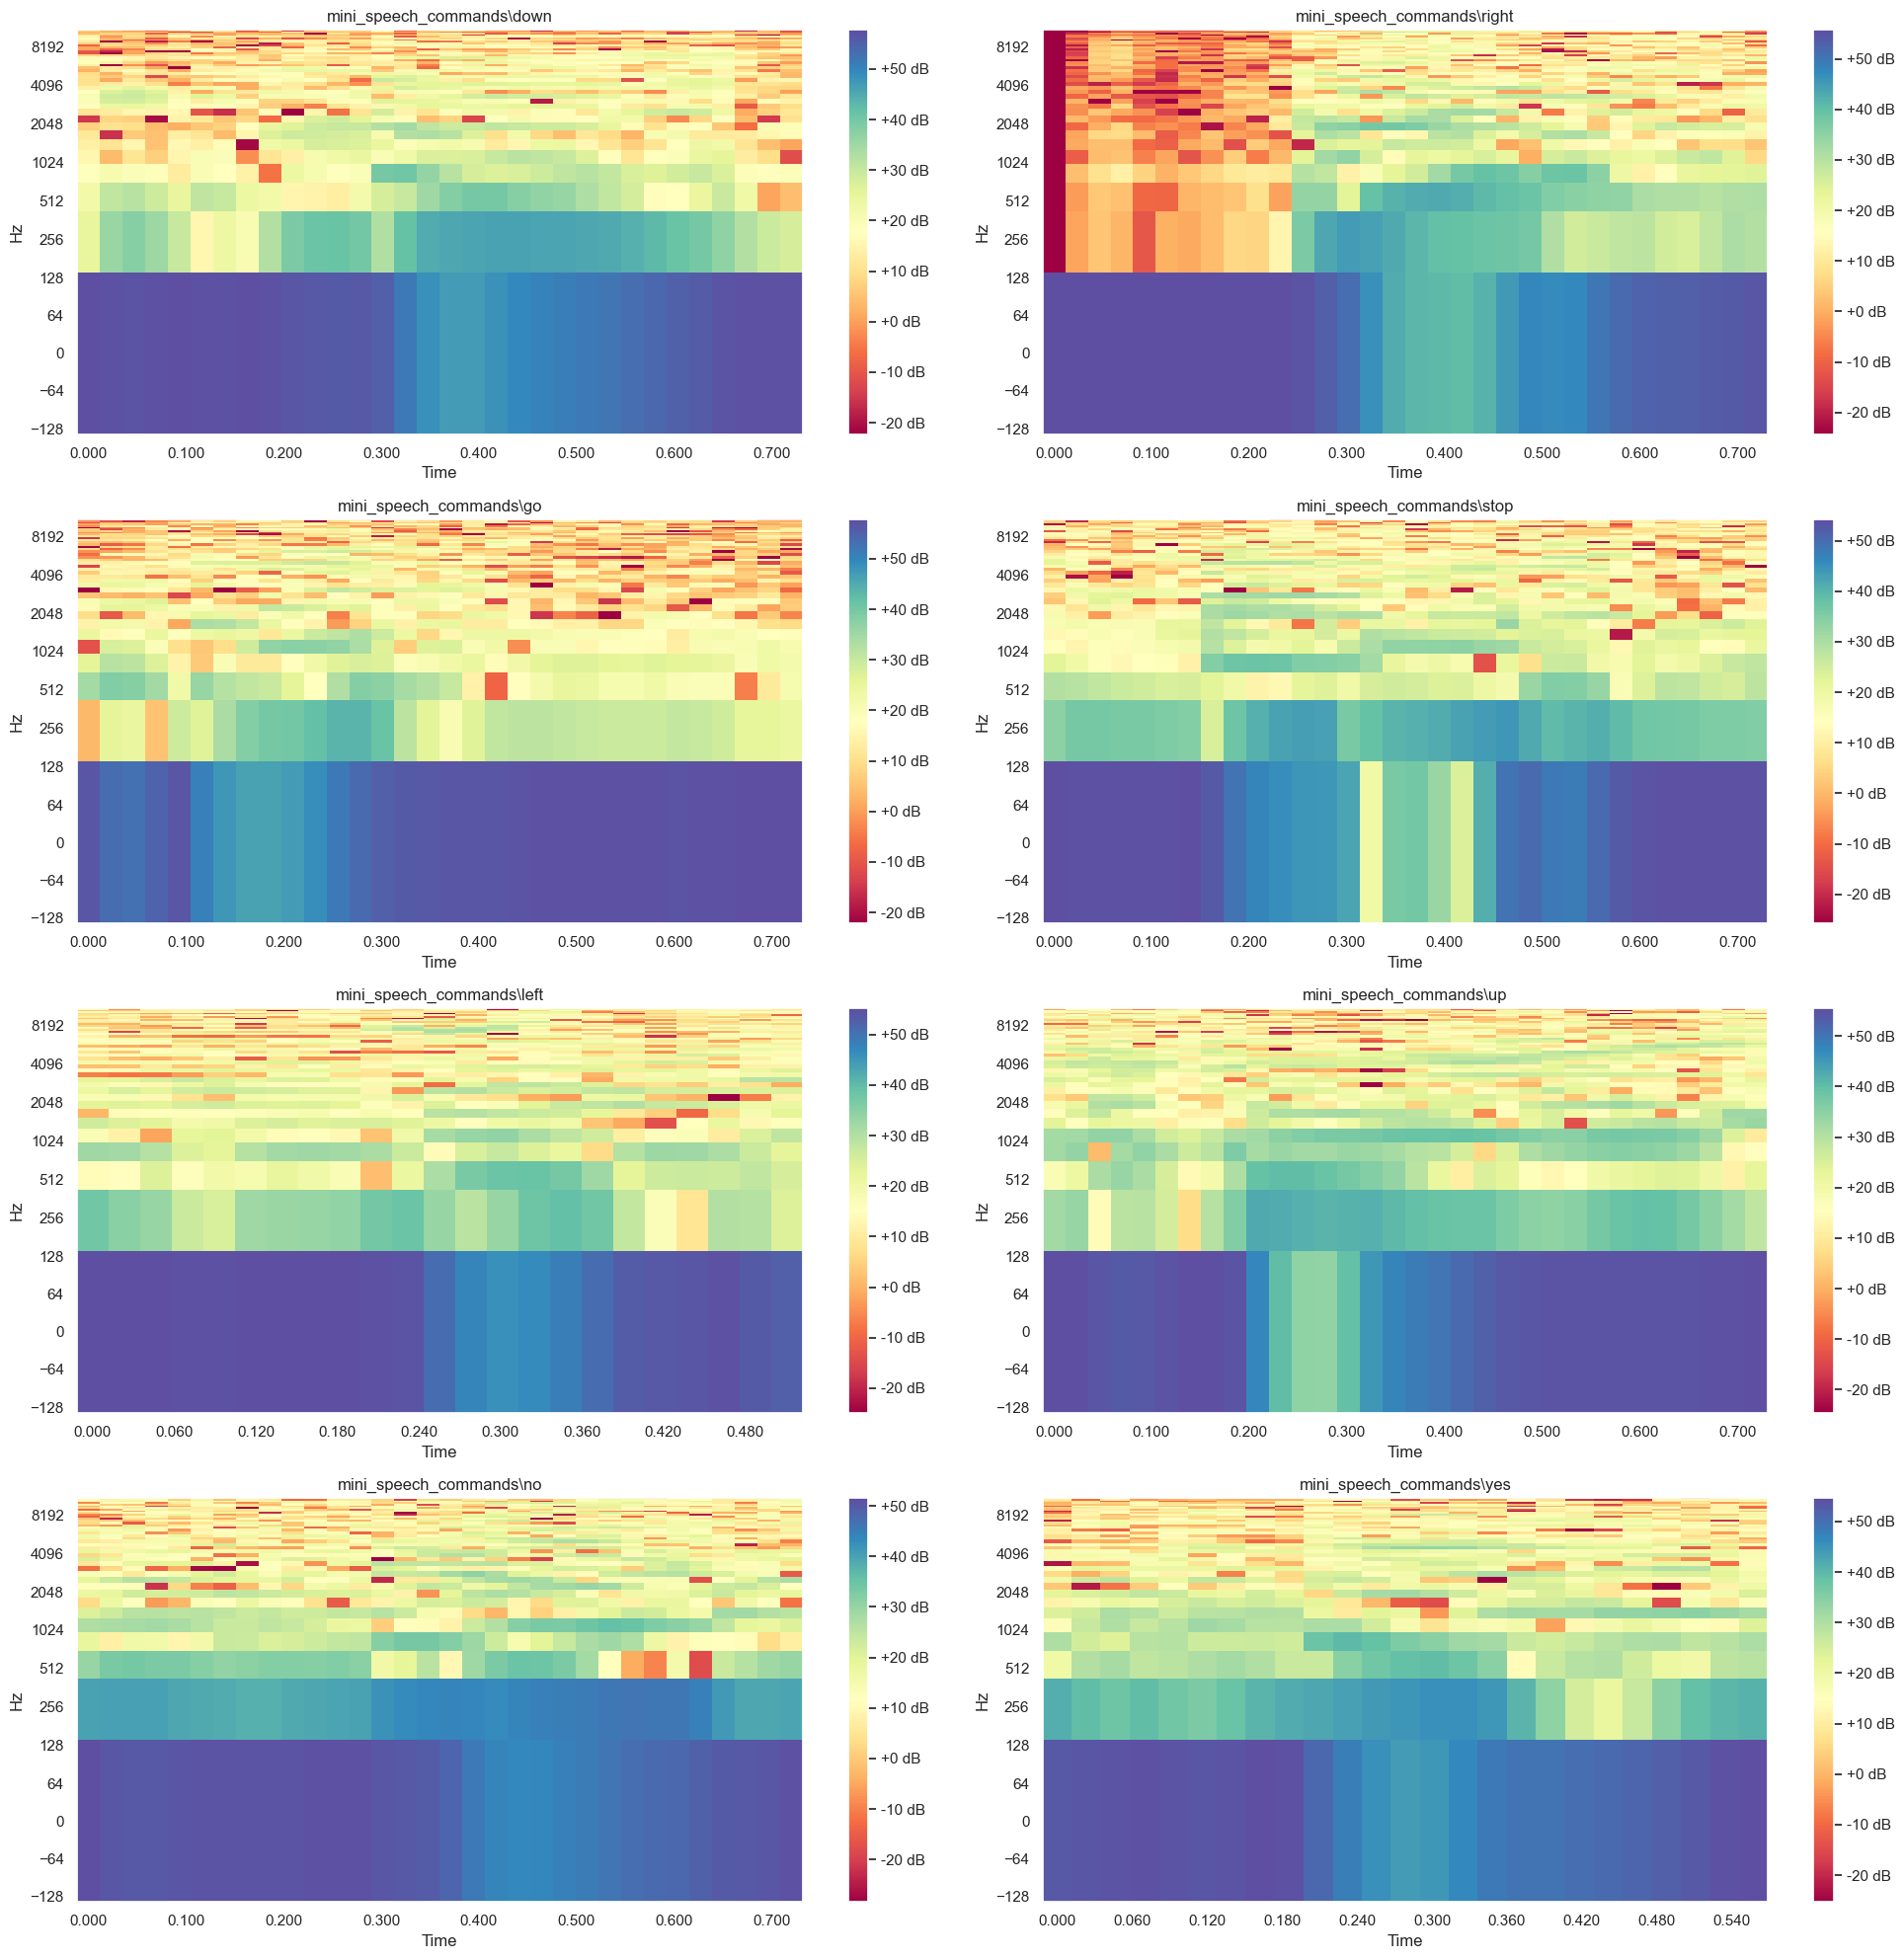

In [25]:
#Espectrogramas de MFCCs

# Cria uma nova figura e um array de subplots com 4 linhas e 2 colunas, com tamanho total de 20x20 polegadas.
fig, axs = plt.subplots(rows, cols, figsize=(20,20))
index = 0
# Itera por cada célula do layout para processar e exibir os espectrogramas de MFCC (Mel-Frequency Cepstral Coefficients) dos arquivos de áudio selecionados.
for col in range(cols):
    for row in range(rows):
        data, sample_rate = librosa.load(audio_samples[index], sr = None)
        mfccs = librosa.feature.mfcc(y = data, sr=sample_rate, n_mfcc=40)
        mfccs_db = librosa.amplitude_to_db(np.abs(mfccs))
        img = librosa.display.specshow(mfccs_db, x_axis="time", y_axis='log', ax=axs[row][col], cmap = 'Spectral')
        axs[row][col].set_title('{}'.format(labels[index]))
        fig.colorbar(img, ax=axs[row][col], format='%+2.f dB')
        index += 1

fig.tight_layout()

In [26]:
# Inicialize uma lista vazia para armazenar os coeficientes MFCC.
speech_data_mfcc = []

# Itere sobre a lista Load_speech_data.
for audio, sample_rate in loaded_speech_data:
    # Extraia MFCCs da amostra de áudio atual.
    mfccs = librosa.feature.mfcc(y=audio, sr=sample_rate)
    # Anexe os MFCCs extraídos à lista.
    speech_data_mfcc.append(mfccs)

In [27]:
#Definindo a proporção da base de dados em treinamento, validação e teste

#70% (0.7) para treinar;
#Para a validação usamos 15% (0.15);
#E para teste o restante da base de dados 15% (0.15).

speech_data_as_tensor = []
# Itera sobre o índice de cada conjunto de coeficientes MFCC em 'speech_data_mfcc'.
for index in range(len(speech_data_mfcc)):
  mfcc_array = np.copy(speech_data_mfcc[index])
  mfcc_array.resize((20,32), refcheck = False)
  speech_data_as_tensor.append(tf.expand_dims(tf.convert_to_tensor(mfcc_array), -1))

In [28]:
# Divide os dados de áudio (tensores) em três conjuntos: treinamento, validação e teste.
# A divisão é feita com base em índices específicos para garantir proporções apropriadas para cada conjunto.
# O conjunto de treinamento consiste nos primeiros 5600 elementos da lista 'speech_data_as_tensor'.
# Isso significa que os dados de 0 até 5599 (inclusive) são utilizados para treinamento.
training_slice = speech_data_as_tensor[:5600]
validation_slice = speech_data_as_tensor[5600:5600 + 1200]
testing_slice = speech_data_as_tensor[5600 + 1200:]

In [29]:
# Cria conjuntos de dados de treinamento, validação e teste usando o TensorFlow.
# 'tf.data.Dataset.from_tensor_slices' é uma função que cria um objeto Dataset do TensorFlow.
# Cada objeto Dataset é composto por pares de elementos, onde cada par contém um tensor de áudio e um rótulo correspondente.
# O conjunto de treinamento ('training_dataset') é criado a partir de 'training_slice' e os primeiros 5600 rótulos de 'speech_label_int'.
# Isso significa que cada elemento do 'training_dataset' contém um tensor de áudio do conjunto de treinamento e seu rótulo correspondente.
training_dataset = tf.data.Dataset.from_tensor_slices((training_slice, speech_label_int[:5600]))
validation_dataset = tf.data.Dataset.from_tensor_slices((validation_slice, speech_label_int[5600:5600+1200]))
testing_dataset = tf.data.Dataset.from_tensor_slices((testing_slice, speech_label_int[-1200:]))

In [30]:
# Definindo o tamanho do lote (batch) para o conjunto de dados de treinamento e validação.
batch_size = 10 # Cada lote contém 10 pares de áudio e rótulo.
training_dataset = training_dataset.batch(batch_size)
validation_dataset = validation_dataset.batch(batch_size)

In [31]:
#Criando o modelo
num_labels = 10

norm_layer = layers.Normalization()
model = models.Sequential([
                           layers.Input(shape=(20,32,1)),
                           layers.Resizing(32,32),
                           norm_layer,
                           layers.Conv2D(32, 3, activation = 'relu'),
                           layers.Conv2D(64, 3, activation='relu'),
                           layers.MaxPooling2D(),
                           layers.Dropout(0.25),
                           layers.Flatten(),
                           layers.Dense(128, activation = 'relu'),
                           layers.Dropout(0.25),
                           layers.Dense(num_labels), # logits
])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resizing (Resizing)             │ (None, 32, 32, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ normalization (Normalization)   │ (None, 32, 32, 1)      │             3 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 30, 30, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 28, 28, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     1,605,760 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,625,869 (6.20 MB)

 Trainable params: 1,625,866 (6.20 MB)

 Non-trainable params: 3 (16.00 B)

In [32]:
# Configurando o processo de compilação do modelo.
# 'model.compile()' é usado para configurar o processo de aprendizado antes do treinamento.
# Este método configura o otimizador, a função de perda e as métricas para monitorar.
model.compile(optimizer = 'adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True), metrics = ['accuracy'])

In [33]:
#Treinando o modelo

EPOCHS = 10
BATCH_SIZE = 64

dir_model = "D:/Dados/Material_complementar_reconhecimento_voz/mini_speech_commands/saved_models/"

checkpointer = (tf.keras.callbacks.EarlyStopping(verbose=1, patience=2),
                tf.keras.callbacks.ModelCheckpoint(filepath=dir_model+'voice_command_recognition.keras',
                                                   save_best_only=True))

start = datetime.now()
model_history = model.fit(training_dataset, validation_data=validation_dataset, batch_size=BATCH_SIZE,
                          epochs=EPOCHS, callbacks=[checkpointer],
)
duration = datetime.now() - start
print("Treinamento concluído em: ", duration)

Epoch 1/10
560/560 ━━━━━━━━━━━━━━━━━━━━ 14s 21ms/step - accuracy: 0.3419 - loss: 2.9083 - val_accuracy: 0.6925 - val_loss: 0.8878
Epoch 2/10
560/560 ━━━━━━━━━━━━━━━━━━━━ 11s 20ms/step - accuracy: 0.6569 - loss: 0.9341 - val_accuracy: 0.7492 - val_loss: 0.7173
Epoch 3/10
560/560 ━━━━━━━━━━━━━━━━━━━━ 11s 20ms/step - accuracy: 0.7575 - loss: 0.6748 - val_accuracy: 0.7708 - val_loss: 0.6841
Epoch 4/10
560/560 ━━━━━━━━━━━━━━━━━━━━ 12s 22ms/step - accuracy: 0.8148 - loss: 0.4957 - val_accuracy: 0.7808 - val_loss: 0.6306
Epoch 5/10
560/560 ━━━━━━━━━━━━━━━━━━━━ 13s 22ms/step - accuracy: 0.8604 - loss: 0.4051 - val_accuracy: 0.7917 - val_loss: 0.6580
Epoch 6/10
560/560 ━━━━━━━━━━━━━━━━━━━━ 11s 20ms/step - accuracy: 0.8793 - loss: 0.3468 - val_accuracy: 0.7975 - val_loss: 0.7060
Epoch 6: early stopping
Treinamento concluído em:  0:01:12.521089


In [34]:
#Avaliando o modelo

# Preparando os dados de áudio e rótulos de teste para avaliação do modelo.
test_audio_data = []
test_label_data = []
# Itera sobre cada par de áudio e rótulo no conjunto de dados de teste.
for audio, label in testing_dataset:
  test_audio_data.append(audio.numpy())
  test_label_data.append(label.numpy())

In [35]:
# Convertendo as listas de dados de áudio e rótulos de teste para arrays NumPy.
test_audio_data = np.array(test_audio_data)
test_label_data = np.array(test_label_data)

In [36]:
# Estabelecendo as predições do modelo
y_pred = np.argmax(model.predict(test_audio_data), axis = 1)
y_true = test_label_data

38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step


In [37]:
print('Taxa de acerto: ', sum(y_pred == y_true) / len(y_true))

Taxa de acerto:  0.8016666666666666


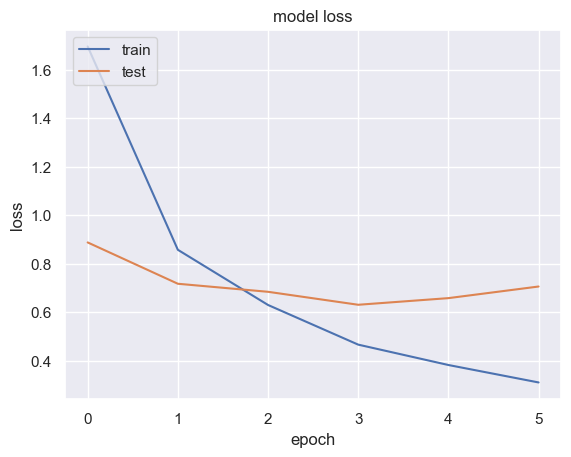

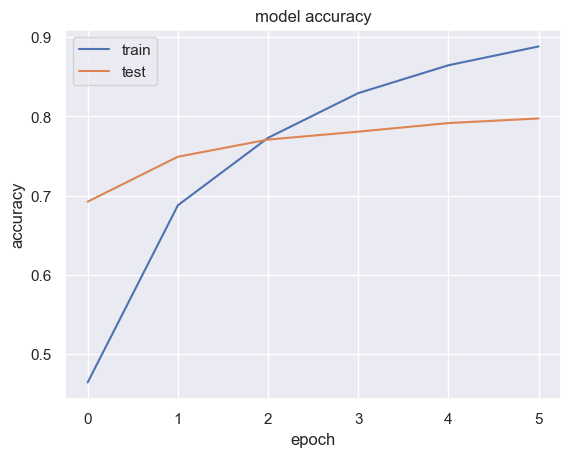

In [38]:
#Exbindo as métricas de precisão e perda do modelo

metrics = model_history.history
plt.plot(model_history.epoch, metrics['loss'], metrics['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(model_history.epoch, metrics['accuracy'], metrics['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

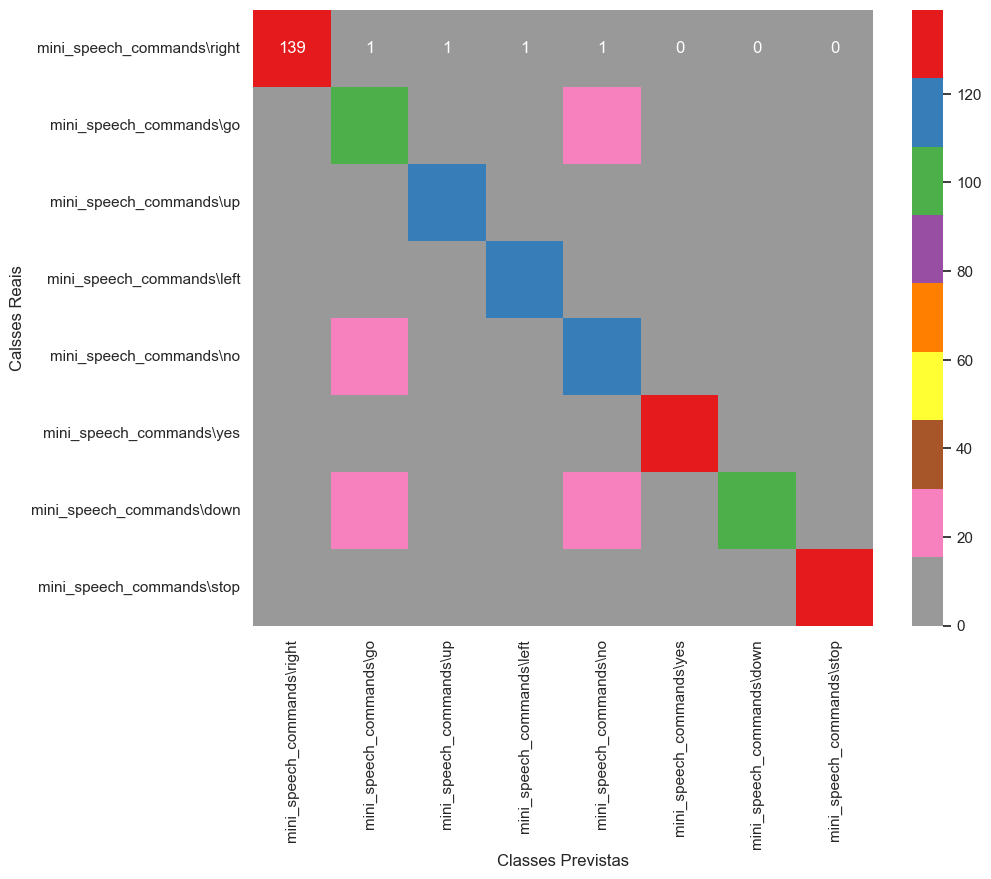

In [39]:
#Exibindo a Matriz de confusão

confusion_mtx = tf.math.confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx, xticklabels=commands_dict, yticklabels=commands_dict, annot=True, fmt='g', cmap='Set1_r')
plt.xlabel('Classes Previstas')
plt.ylabel('Calsses Reais')
plt.show()